Opracować według własnego pomysłu graficzną prezentację zawierającą informacje o konkretnym genie lub genach, substancjach leczniczych, które z tym genem/genami wchodzą w interakcje, oraz produktach farmaceutycznych, które zawierają daną substancję leczniczą. Wybór dotyczący tego, czy prezentacja graficzna jest realizowana dla konkretnego genu, czy wszystkich genów jednocześnie pozostawiamy Państwa decyzji. Przy dokonywaniu wyboru należy kierować się czytelnością i atrakcyjnością prezentacji graficznej.

In [2]:
import pandas as pd
from lxml import etree
import networkx as nx
import matplotlib.pyplot as plt
from pprint import pprint
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

In [3]:
path = 'data/drugbank_partial.xml'
ns = {'db': 'http://www.drugbank.ca'}

In [4]:
tree = etree.parse(path)
root = tree.getroot()

In [5]:
def unwrap(field, node: etree._Element):
    return getattr(node.find(f"db:{field}", ns), "text", None)

In [6]:
def unwrap_attrib(attrib, node: etree._Element):
    return node.attrib.get(attrib)

In [7]:
def gene_graph(gene_name):
    graph = nx.DiGraph()
    graph.add_node(gene_name)
    
    for polypeptide in root.findall(f"db:drug/db:targets/db:target/db:polypeptide[db:gene-name='{gene_name}']", ns):
        drug = polypeptide.find('../../..', ns)
        drug_name = unwrap("name", drug)
        graph.add_edge(gene_name, drug_name)
        for product in drug.findall('db:products/db:product', ns):
            product_str = f"{unwrap('name', product)} ({unwrap('dosage-form', product)})"
            graph.add_edge(drug_name, product_str)
        
    return graph

In [8]:
def visualize_gene(gene_name):
    graph = gene_graph(gene_name)
    
    # pos = nx.bfs_layout(graph, start=gene_name)
    # pos = nx.shell_layout(graph)
    # pos = nx.spring_layout(graph, k=0.3, iterations=100)
    pos = graphviz_layout(graph, prog="twopi")
    
    plt.figure(figsize=(10,10))
    nx.draw(
        graph,
        pos,
        with_labels=True,
        node_size=1000, 
        font_size=8,
        node_color="#dddddd",
        edge_color="#aaaaaa",
    )
    plt.show()

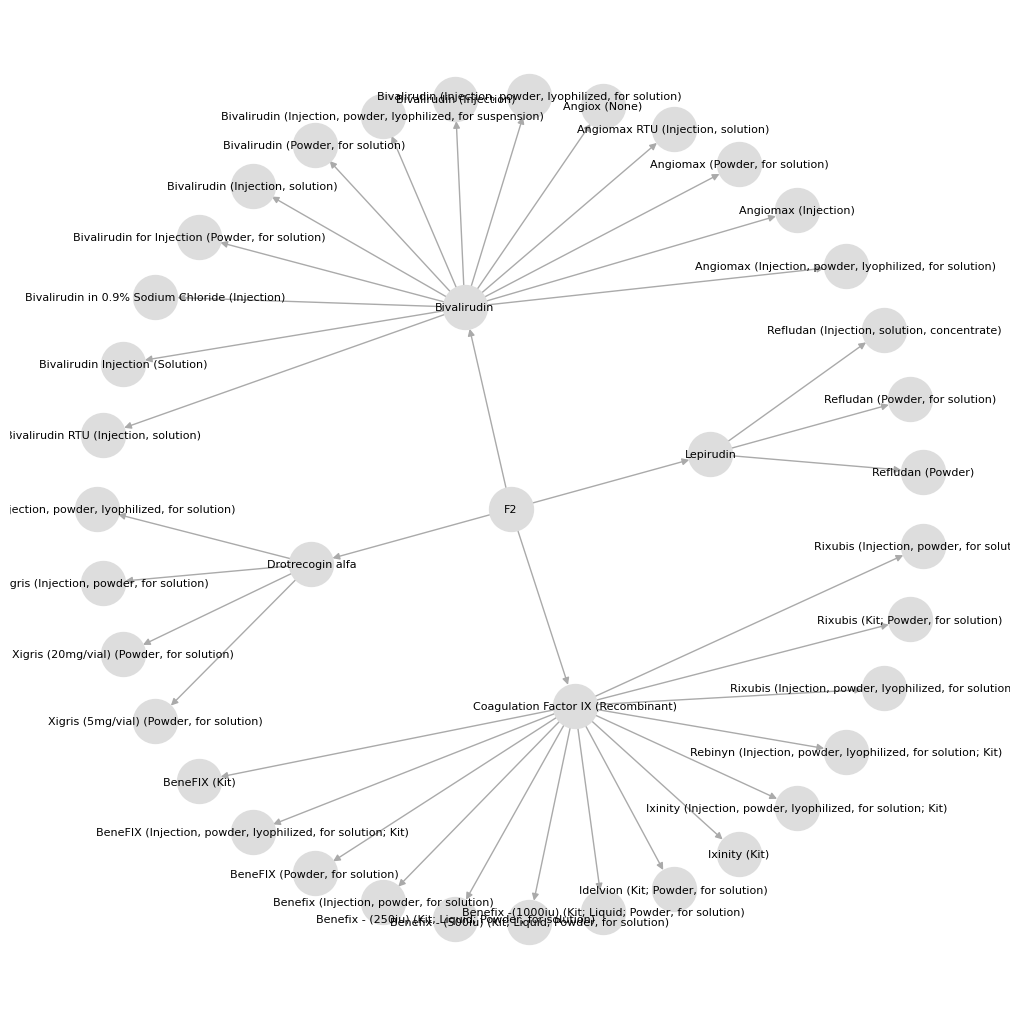

In [11]:
visualize_gene("F2")

In [62]:
def all_genes_df():
    genes = set()
    data = []
    for drug in root.findall('db:drug', ns):
        for polypeptide in drug.findall('db:targets/db:target/db:polypeptide', ns):
            genes.add(unwrap("gene-name", polypeptide))
            data.append({
                "Drug": unwrap("name", drug),
                "Gene": unwrap("gene-name", polypeptide),
            })
    return genes, pd.DataFrame(data)

In [44]:
genes, df = all_genes_df()
df

,Drug,Gene
0,Lepirudin,F2
1,Cetuximab,EGFR
2,Cetuximab,FCGR3B
3,Cetuximab,C1QA
4,Cetuximab,C1QB
...,...,...
247,Oxytocin,OXTR
248,Natalizumab,ITGA4
249,Natalizumab,FCGR3B
250,Natalizumab,FCGR1A
